In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler, ModelCheckpoint

In [3]:
print('tensroflow version: ' + tf.__version__)
print('keras version     : ' + keras.__version__)

tensroflow version: 1.13.1
keras version     : 2.2.4-tf


In [2]:
# 限制 GPU 使用大小（keras版）
gpu_option = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_option))
tf.keras.backend.set_session(sess)

In [3]:
cifar_dir = "./dataset/cifar10/"

### 資料下載與另存（首次需要執行）

In [5]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [129]:
cifar10_name = ['airplain', 'automobile', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck']

In [93]:
# training data 落地
for i, item in enumerate(cifar10_name):
    image = x_train[np.where(y_train.squeeze() == i)]
    j = 0
    for im in image:
        cv2.imwrite(cifar_dir + 'train/' + item + '/' + str(j) + '.jpg', 
                    im[:,:,(2,1,0)])
        j += 1

In [143]:
# validation data 落地
for i, item in enumerate(cifar10_name):
    image = x_test[np.where(y_test.squeeze() == i)]
    j = 0
    for im in image:
        cv2.imwrite(cifar_dir + 'validtion/' + item + '/' + str(j) + '.jpg', 
                    im[:,:,(2,1,0)])
        j += 1

### 資料預處理

In [4]:
# Z-score
# 一個 model 直接 fine tune val_acc 會非常差
# 但有先只訓練 fc 在 fine tune 的話，效果不會差太多
def color_preprocess(data):
    data = data.astype('float32')
    _COLOR_MEAN = [125.307, 122.950, 113.865]
    _COLOR_STD = [62.9932, 62.0887, 66.7048]
    for i in range(3):
        data[...,i] = (data[...,i]-_COLOR_MEAN[i]) / _COLOR_STD[i]
    return data

In [4]:
# imageNet diff mean
def color_preprocess(data):
    data = data.astype('float32')
    _COLOR_MEAN = [123.68, 116.779, 103.939]
   
    for i in range(3):
        data[...,i] = (data[...,i]-_COLOR_MEAN[i])
    return data

In [5]:
IMAGE_SIZE = 224
batch_size = 32

In [6]:
train_datagen = ImageDataGenerator(
    rotation_range=25,           # 隨機旋轉度數範圍
    shear_range=0.2,             # 剪切強度
    horizontal_flip=True,        # 隨機水平翻轉 
    width_shift_range=0.15,     # 水平平移
    height_shift_range=0.15,    # 垂直平移
    fill_mode='nearest',         # 填充方式
    # cval=0,                      # 補值=0 
    #rescale=1./255,
    preprocessing_function=color_preprocess
)
train_generator = train_datagen.flow_from_directory(
    cifar_dir + 'train', 
    target_size=(IMAGE_SIZE, IMAGE_SIZE), 
    batch_size=batch_size,
    class_mode='categorical',
)

validation_datagen = ImageDataGenerator(
    # rescale=1./255,
    preprocessing_function=color_preprocess
)
validation_generator = validation_datagen.flow_from_directory(
    cifar_dir + 'validation', 
    target_size=(IMAGE_SIZE, IMAGE_SIZE), 
    batch_size=batch_size,
    class_mode='categorical'
)

Found 50000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


### Transfer Learning

pre train model 為 resnet50，但 resnet 在 BN 層上會有問題（尤其是 transfer learning），
詳細可以參考這個[網站](http://blog.datumbox.com/the-batch-normalization-layer-of-keras-is-broken/)

In [7]:
base_model = ResNet50(
    include_top=False,
    weights='imagenet',  
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    pooling='avg',
)

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
# 對於 fc 層嘗試使用 gelu 作為 activation function
def gelu(x):
    cdf = 0.5 * (1.0 + tf.tanh(
        (np.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3)))))
    return x * cdf

In [9]:
def scheduler(epoch):
    if epoch < 3:
        return 5e-4
    else:
        return 1e-4

In [10]:
cbks = [TensorBoard(log_dir='./keras_model/log/resnet', histogram_freq=0),
        LearningRateScheduler(scheduler),
        ModelCheckpoint('./keras_model/resnet_finetune.h5',
                        monitor='val_acc', save_best_only=True)]

In [11]:
base_model.trainable = False

In [12]:
# 確認沒做任何動作前的可訓練參數層
len(base_model.trainable_weights)

0

In [13]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [14]:
norm_l2 = keras.regularizers.l2(0.00001)

main_model = keras.Sequential([
    base_model,
    # keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2048, activation=gelu, 
                       kernel_initializer='he_normal',
                       kernel_regularizer=norm_l2),
    keras.layers.Dense(256, activation=gelu, 
                       kernel_initializer='he_normal',
                       kernel_regularizer=norm_l2),
    keras.layers.Dense(10, activation='softmax'),
])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [15]:
main_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 28,311,178
Trainable params: 4,723,466
Non-trainable params: 23,587,712
_________________________________________________________________


In [16]:
main_model.compile(optimizer=keras.optimizers.Adam(lr=0.0005),
                   loss=tf.keras.losses.categorical_crossentropy,
                   metrics=['accuracy'])

In [17]:
epoch = 6
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

In [18]:
history = main_model.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=epoch, 
    validation_data=validation_generator, 
    validation_steps=validation_steps,
    # callbacks=cbks,
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/6
1563/1563 [==============================] - 465s 297ms/step - loss: 1.2906 - acc: 0.5624 - val_loss: 0.9305 - val_acc: 0.6890
Epoch 2/6
1563/1563 [==============================] - 462s 296ms/step - loss: 1.1389 - acc: 0.6179 - val_loss: 0.8482 - val_acc: 0.7239
Epoch 3/6
1563/1563 [==============================] - 460s 294ms/step - loss: 1.0988 - acc: 0.6321 - val_loss: 0.9067 - val_acc: 0.7014
Epoch 4/6
1563/1563 [==============================] - 461s 295ms/step - loss: 1.0188 - acc: 0.6624 - val_loss: 0.7751 - val_acc: 0.7485
Epoch 5/6
1563/1563 [==============================] - 461s 295ms/step - loss: 0.9916 - acc: 0.6704 - val_loss: 0.7665 - val_acc: 0.7488
Epoch 6/6
1563/1563 [==============================] - 461s 295ms/step - loss: 0.9746 - acc: 0.6733 - val_loss: 0.7517 - val_acc: 0.7531


### Fine Tune

In [19]:
base_model.trainable = True

In [20]:
# 以 block5 後來進行 fine tune
set_trainable = False
for layer in base_model.layers:
    if layer.name == 'res5a_branch2a':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [21]:
# 確認 fine tune 數量改變
len(base_model.trainable_weights)

40

In [22]:
main_model.compile(optimizer=keras.optimizers.Adam(lr=0.00002),
                   loss=tf.keras.losses.categorical_crossentropy,
                   metrics=['accuracy'])

In [23]:
main_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 28,311,178
Trainable params: 19,699,466
Non-trainable params: 8,611,712
_________________________________________________________________


In [24]:
history_finetune = main_model.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=12, 
    validation_data=validation_generator, 
    validation_steps=validation_steps,
    callbacks=cbks,
)

Epoch 1/12
1563/1563 [==============================] - 460s 294ms/step - loss: 0.7655 - acc: 0.7531 - val_loss: 0.6391 - val_acc: 0.7985
Epoch 2/12
1563/1563 [==============================] - 457s 293ms/step - loss: 0.5688 - acc: 0.8202 - val_loss: 0.5017 - val_acc: 0.8470
Epoch 3/12
1563/1563 [==============================] - 456s 292ms/step - loss: 0.4991 - acc: 0.8441 - val_loss: 0.5669 - val_acc: 0.8305
Epoch 4/12
1563/1563 [==============================] - 458s 293ms/step - loss: 0.3737 - acc: 0.8841 - val_loss: 0.3696 - val_acc: 0.8862
Epoch 5/12
1563/1563 [==============================] - 457s 292ms/step - loss: 0.3276 - acc: 0.8974 - val_loss: 0.3576 - val_acc: 0.8915
Epoch 6/12
1563/1563 [==============================] - 456s 292ms/step - loss: 0.3072 - acc: 0.9054 - val_loss: 0.3346 - val_acc: 0.8980
Epoch 7/12
1563/1563 [==============================] - 456s 292ms/step - loss: 0.2825 - acc: 0.9137 - val_loss: 0.3286 - val_acc: 0.9009
Epoch 8/12
1563/1563 [============

In [25]:
acc = history.history['acc'] + history_finetune.history['acc']
loss = history.history['loss'] + history_finetune.history['loss']
val_acc = history.history['val_acc'] + history_finetune.history['val_acc']
val_loss = history.history['val_loss'] + history_finetune.history['val_loss']

In [38]:
def model_history(acc, loss, val_acc, val_loss):
    print('training acc   : ' + str(np.round(acc, 4)))
    print('validation acc : ' + str(np.round(val_acc, 4)))
    print('training loss  : ' + str(np.round(loss, 4)))
    print('validation loss: ' + str(np.round(val_loss, 4)))
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.plot([epoch-0.5, epoch-0.5], plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()), 1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.plot([epoch-0.5, epoch-0.5], plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.ylim([0, max(plt.ylim())])
    plt.title('Training and Validation Loss')
    plt.show()

training acc   : [0.5624 0.6179 0.6321 0.6624 0.6704 0.6733 0.7531 0.8202 0.8441 0.8841
 0.8974 0.9054 0.9137 0.9182 0.9211 0.9286 0.9306 0.9362]
validation acc : [0.689  0.7239 0.7014 0.7485 0.7488 0.7531 0.7985 0.847  0.8305 0.8862
 0.8915 0.898  0.9009 0.9037 0.9062 0.9085 0.8985 0.9042]
training loss  : [1.2905 1.139  1.0988 1.0189 0.9916 0.9744 0.7654 0.5688 0.4991 0.3738
 0.3276 0.3072 0.2825 0.2647 0.2529 0.2349 0.2274 0.2142]
validation loss: [0.9305 0.8482 0.9067 0.7751 0.7665 0.7517 0.6391 0.5017 0.5669 0.3696
 0.3576 0.3346 0.3286 0.3277 0.3196 0.3107 0.3478 0.3187]


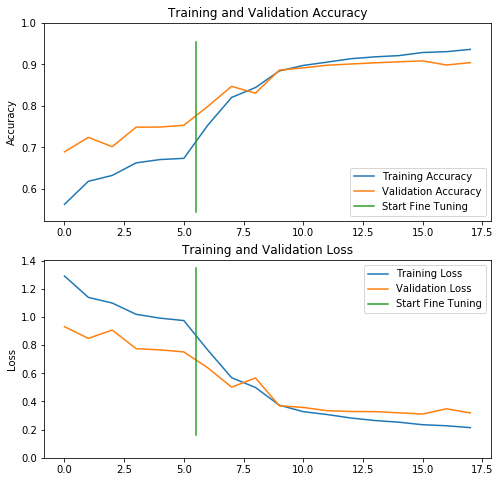

In [39]:
model_history(acc, loss, val_acc, val_loss)

### 模型測試

In [43]:
# 使用 custom_objects 加載有自定義方法的模型
model = keras.models.load_model('./keras_model/resnet_finetune.h5', 
                                custom_objects={'gelu': gelu})

In [58]:
# lables list
cifar10_name = ['airplain', 'automobile', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck']

In [143]:
def prediction_image(image_path, model):
    img = cv2.imread(image_path)[:,:,::-1]
    img_preprocess = color_preprocess(img)
    img_resize = cv2.resize(img_preprocess, (224, 224), interpolation=cv2.INTER_CUBIC)
    img_arr = np.expand_dims(img_resize, axis=0)
    outcome = model.predict(img_arr)[0]
    outcome_sort = outcome.argsort()[::-1][:5]
    plt.imshow(img)
    for i in outcome_sort:
        print('{:.3f}  {}'.format(outcome[i], cifar10_name[i]))

In [149]:
image_path = 'YOUR_IMAGE_PATH'

0.865  airplain
0.055  automobile
0.046  ship
0.030  bird
0.002  cat


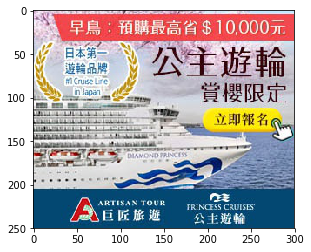

In [150]:
prediction_image(image_path, model)

### Reference

1. [TensorFlow 官網教程](https://www.tensorflow.org/alpha/tutorials/images/transfer_learning)
2. [Keras Blog 教程](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)
3. [網路上 github 的教程](https://github.com/PrzemekPobrotyn/CIFAR-10-transfer-learning/blob/master/report.ipynb)，他提及了 keras resnet50 的 BN 層會存在問題。
4. [BN層的補釘](http://blog.datumbox.com/the-batch-normalization-layer-of-keras-is-broken/)，清楚介紹 BN 層存在的問題以及提供補釘，雖然我沒有使用補釘。
5. [G. T. Wang 的教程](https://blog.gtwang.org/programming/keras-resnet-50-pre-trained-model-build-dogs-cats-image-classification-system/)